In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir('/content/drive/My Drive/Data Science Projects/RoyGPT'))
roy_gpt_path = '/content/drive/My Drive/Data Science Projects/RoyGPT'

['Succession_Season_One.pdf', 'Succession_Season_Two.pdf', 'Succession_Season_Three.pdf', 'Succession_Season_Four.pdf', 'RoyGPT Project Management.gsheet', 'RoyGPT.gdoc', 'roman_roy_sarcasm_labeled.gsheet', 'TextGeneration_SuccessionStyle.ipynb']


Defining file paths

In [ ]:
season_one_path = os.path.join(roy_gpt_path, 'Succession_Season_One.pdf')
season_two_path = os.path.join(roy_gpt_path, 'Succession_Season_Two.pdf')
season_three_path = os.path.join(roy_gpt_path, 'Succession_Season_Three.pdf')
season_four_path = os.path.join(roy_gpt_path, 'Succession_Season_Four.pdf')

**pdfplumber** is effective at extracting text from PDFs, especially when the layout is complex.

In [ ]:
# !pip install pdfplumber==0.11.3

This function takes the path to a PDF file (pdf_path) as input and **returns all the text content of the PDF** as a single string.

In [ ]:
# import pdfplumber

# def extract_text_from_pdf(pdf_path):
#     text = ""
#     with pdfplumber.open(pdf_path) as pdf:
#         for page in pdf.pages:
#             text += page.extract_text()
#     return text

In [ ]:
# text_season_one = extract_text_from_pdf(season_one_path)
# text_season_two = extract_text_from_pdf(season_two_path)
# text_season_three = extract_text_from_pdf(season_three_path)
# text_season_four = extract_text_from_pdf(season_four_path)

In [ ]:
# # Build a dictionary
# seasons_dict = {
#     'Season 1': text_season_one,
#     'Season 2': text_season_two,
#     'Season 3': text_season_three,
#     'Season 4': text_season_fourA
# }
# # Print the first 500 characters of the text from the first PDF as an example
# print(list(seasons_dict.values())[0][:500])

Attempt to trim text: **FAILED**

In [ ]:
# import re

# def trim_script(text):
#     # Look for the first occurrence of the word 'EPISODE' in a case-sensitive manner
#     text = text.strip()
#     match = re.search(r'\bEPISODE\b', text)

#     if match:
#         # Return the text starting from the first occurrence of 'EPISODE'
#         return text[match.start():]

#     # If 'EPISODE' is not found, return the original text
#     return text

# # Apply the trimming function to each season's text
# for season in seasons_dict:
#     seasons_dict[season] = trim_script(seasons_dict[season])

# # Print the first 500 characters of the trimmed text to verify
# print(list(seasons_dict.values())[0][:500])


Extracting Roman Roy's Dialogues: FAILED

In [ ]:
# import re

# def extract_roman_dialogues(season_text):
#     roman_dialogues = []
#     # Regex pattern to match Roman's name and capture his dialogues
#     pattern = r'\bROMAN\b\s*(.*?)(?=\n[A-Z ]+\n|\n\n|\Z)'
#     matches = re.findall(pattern, season_text, re.DOTALL)

#     for match in matches:
#         # Clean up the dialogue, removing stage directions in parentheses
#         dialogue = re.sub(r'\(.*?\)', '', match).strip()
#         # Append non-empty dialogue
#         if dialogue:
#             roman_dialogues.append(dialogue)

#     return roman_dialogues

# # Apply the function to extract Roman's dialogues
# roman_dialogues_season_one = extract_roman_dialogues(text_season_one)

# # Print the first few dialogues to verify
# print(roman_dialogues_season_one[:10])

^Issues Identified:
Non-dialogue Text Still Present:

Phrases like "ROY\nAlan Ruck" and stage directions such as "The business alchemist starts to pack up his kit." and "Logan walks the unfamiliar rooms of his large new apartment..." are incorrectly included in the output.
Combining Multiple Dialogue Blocks:

The extraction sometimes combines Roman's dialogue with other character’s actions or stage directions, making the output cluttered and less useful.


In [ ]:
# import re

# def extract_roman_dialogues(season_text):
#     roman_dialogues = []
#     # Regex pattern to match Roman's name and capture his dialogues
#     pattern = r'\bROMAN\b\s*\n(.*?)(?=\n[A-Z ]+\n|\n{2,}|\Z)'
#     matches = re.findall(pattern, season_text, re.DOTALL)

#     for match in matches:
#         # Filter out known non-dialogue text (e.g., cast lists)
#         if "Alan Ruck" in match or re.match(r'^\s*$', match):
#             continue
#         # Clean up the dialogue, removing stage directions and extra text
#         cleaned_dialogue = re.sub(r'\(.*?\)', '', match)  # Remove anything in parentheses (stage directions)
#         cleaned_dialogue = re.sub(r'\n+', ' ', cleaned_dialogue)  # Replace newlines within the dialogue with spaces
#         cleaned_dialogue = cleaned_dialogue.strip()  # Remove leading and trailing whitespace

#         # Further cleanup to remove any potential remnants of italic indicators if they exist (heuristic approach)
#         # Assuming no special characters for italics, but just spaces or odd formatting, we handle it by a regex like:
#         cleaned_dialogue = re.sub(r'\*.*?\*', '', cleaned_dialogue)  # Example of removing something in stars or similar

#         # Filter out any line that consists of just uppercase words (often non-dialogue text)
#         if re.match(r'^[A-Z ]+$', cleaned_dialogue):
#             continue
#         if cleaned_dialogue:
#             roman_dialogues.append(cleaned_dialogue)

#     return roman_dialogues

# # Apply the function to extract Roman's dialogues
# roman_dialogues_season_one = extract_roman_dialogues(text_season_one)

# # Print the first few dialogues to verify
# print(roman_dialogues_season_one[:10])

^ISSUE: still includes scene descriptions in the dialogue.

IDEA: remove italicized text (used a lot for scene descriptions in this PDF)

OPTION: Using PyMuPDF (fitz)
PyMuPDF is another Python library that can be used to extract text while retaining some formatting information, including whether text is italicized. This library can extract text along with font information, which can be used to detect italics.

In [ ]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 13.2 MB/s eta 0:00:00


**Extract Text with Italics**
All dialogues in this script are italicized.

In [ ]:
import fitz  # PyMuPDF

def extract_text_with_italics(pdf_path):
    doc = fitz.open(pdf_path)
    text_blocks = []

    for page in doc:
        blocks = page.get_text("dict")["blocks"]
        for block in blocks:
            # Check if 'lines' key exists in the block
            if "lines" in block:
                for line in block["lines"]:
                    line_text = ""
                    for span in line["spans"]:
                        # Check if the font style indicates italics (could vary by PDF)
                        if "italic" in span["font"].lower():
                            line_text += f"*{span['text']}*"  # Use *text* to indicate italics
                        else:
                            line_text += span["text"]
                    text_blocks.append(line_text)

    return "\n".join(text_blocks)

**Extracting dialogues for each season**

In [ ]:
text_season_one = extract_text_with_italics(season_one_path)
text_season_two = extract_text_with_italics(season_two_path)
text_season_three = extract_text_with_italics(season_three_path)
text_season_four = extract_text_with_italics(season_four_path)

In [ ]:
# Build a dictionary
seasons_dict = {
    'Season 1': text_season_one,
    'Season 2': text_season_two,
    'Season 3': text_season_three,
    'Season 4': text_season_four
}
# Print the first 500 characters of the text from the first PDF as an example
print(list(seasons_dict.values())[0][:500])

SUCCESSION

SEASON ONE
The Complete Scripts
Contents
Title Page
Introduction by Jesse Armstrong
Note on the Text
SUCCESSION – SEASON ONE
Credits
1. Celebration
2. Shit Show at the Fuck Factory
3. Lifeboats
4. Sad Sack Wasp Trap
5. I Went to Market
6. Which Side Are You On?
7. Austerlitz
8. Prague
9. Pre-Nuptial
10. Nobody Is Ever Missing
Acknowledgements
Copyright
Introduction
My first vivid memory of the project which would develop into
*Succession *was trying to get out of it. It was about 200


**Extracting Roman Roy's dialogues with heuristics**

In [ ]:
import re

def extract_roman_dialogues(text_with_italics):
    roman_dialogues = []
    # Adjusted regex pattern to handle potential special cases more robustly
    pattern = r'\bROMAN\b\s*(.*?)(?=\n[A-Z ]+\n|\n{2,}|\Z)'
    matches = re.findall(pattern, text_with_italics, re.DOTALL)

    for match in matches:
        # Remove stage directions (marked with asterisks for italics)
        cleaned_dialogue = re.sub(r'\*.*?\*', '', match)  # Remove italicized text within asterisks
        cleaned_dialogue = re.sub(r'\s*\(\s*\)', '', cleaned_dialogue)  # Remove empty parentheses
        cleaned_dialogue = re.sub(r'\n+', ' ', cleaned_dialogue)  # Replace newlines within the dialogue with spaces
        cleaned_dialogue = re.sub(r'\*\s*$', '', cleaned_dialogue)  # Remove any trailing asterisks
        cleaned_dialogue = cleaned_dialogue.strip()  # Remove leading and trailing whitespace

        # Filter out non-dialogue lines (e.g., scene headings like INT. LOGAN'S HOME, or erroneous captures)
        if re.match(r'^[A-Z ]+$', cleaned_dialogue) or "INT." in cleaned_dialogue or "EXT." in cleaned_dialogue or "’S" in cleaned_dialogue:
            continue
        if cleaned_dialogue:
            roman_dialogues.append(cleaned_dialogue)

    return roman_dialogues

**Key Improvements:**

*Stage Directions Removed*: The italicized text that was previously marked by asterisks, such as stage directions, is no longer present in the dialogue.

*Clean Dialogues:* The dialogues are clean, with no extraneous formatting or content, except for one small instance of leftover stage direction at the end of the last line.

In [ ]:
# Initialize an empty dictionary to hold Roman's dialogues for each season
roman_dialogues_dict = {}

# Loop through each season's text in the dictionary
for season, text in seasons_dict.items():
    # Extract Roman's dialogues from the current season's text
    roman_dialogues = extract_roman_dialogues(text)
    # Store the extracted dialogues in the dictionary
    roman_dialogues_dict[season] = roman_dialogues

# Print out the first few dialogues from each season to verify
for season, dialogues in roman_dialogues_dict.items():
    print(f"{season}: {dialogues[:3]}")  # Print the first 3 dialogues as a sample

Season 1: ['Hey hey hey, motherfuckers!', 'My guy? Are you saging?', 'Right, bad juju. Maybe you should make a move, dude?']
Season 2: []
Season 3: ['Yeah? I mean, what’s the play?', 'Dad? Dad? You want me to ride with you, talk things through?', 'I dunno. I mean that’s a question I often ask myself.']
Season 4: ['Um, no. Next. Right, fuckchops?', 'Exciting.', 'Hard no.']


In [ ]:
roman_dialogues_dict

{'Season 1': ['Hey hey hey, motherfuckers!',
  'My guy? Are you saging?',
  'Right, bad juju. Maybe you should make a move, dude?',
  'I think just fuck off thanks. How’s it going?',
  'Of course I’m okay. Obviously I’m okay. Why do you ask? What here? Oh, man, I’m so over all this. I was a bad fit. I was never a corporate cock-suck anyway. Besides. I never got this high in the fucking building! They stuck me in LA with Old Father Time, we were the pool boys, right, Frank. Fucking banana cabana? So. What’s the bid?',
  'What that’s ‘commercially sensitive’ – I’m still on the board, bro!',
  'One-twenty-five! Fuck!?',
  'Hey, Global Tom! How you shaking? You still fucking shit up for us?',
  'Sis. The pols still boring the living shit out of you?',
  'Ha! Look at you.* Walking around like you’re an actual human person!',
  'Yeah you wish!',
  'Happy birthday, Dad.',
  'O-kay! Now the fucking’s started!  you’re getting fucked!',
  'PPG are balls deep in him. Hustling up a rival bid.',
  

**Tokenization and Text Cleaning:**
Prepare the text for any further analysis, model training, or other NLP tasks by breaking it into individual tokens (words, phrases) and performing additional cleaning if needed.

In [ ]:
!pip install editdistance

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import re
import editdistance

# Ensure necessary NLTK data is available
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

def tokenize_and_clean(dialogues):
    stop_words = set(stopwords.words('english'))  # Get the list of stopwords
    all_tokens = []
    for dialogue in dialogues:
        # Remove any remaining special characters
        cleaned_dialogue = re.sub(r'[^\w\s]', '', dialogue)  # Remove punctuation, keep words and spaces
        # Tokenize the dialogue
        tokens = word_tokenize(cleaned_dialogue.lower())  # Tokenize and convert to lowercase

        # Handle misspelled stopwords using fuzzy matching
        cleaned_tokens = []
        for token in tokens:
            if not any(editdistance.eval(token, stop_word) <= 2 for stop_word in stop_words):
                cleaned_tokens.append(token)

        all_tokens.extend(cleaned_tokens)

    return all_tokens

# Apply tokenization and cleaning to each season
tokenized_dialogues = {}
for season, dialogues in roman_dialogues_dict.items():
    tokenized_dialogues[season] = tokenize_and_clean(dialogues)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


***Exploratory Data Analysis (EDA):***

Once we have tokenized the text, we can perform some exploratory data analysis to understand Roman's dialogues better.

In [ ]:
tokenized_dialogues

{'Season 1': ['motherfuckers',
  'maybe',
  'obviously',
  'corporate',
  'cocksuck',
  'anyway',
  'besides',
  'fucking',
  'building',
  'frank',
  'fucking',
  'banana',
  'cabana',
  'commercially',
  'sensitive',
  'board',
  'onetwentyfive',
  'global',
  'fucking',
  'walking',
  'around',
  'like',
  'actual',
  'human',
  'person',
  'happy',
  'birthday',
  'fuckings',
  'started',
  'getting',
  'fucked',
  'hustling',
  'rival',
  'piece',
  'trying',
  'unnecessary',
  'sourdough',
  'deal',
  'excuse',
  'print',
  'asshole',
  'laughing',
  'private',
  'fourteen',
  'advice',
  'suckup',
  'great',
  'doublevotepower',
  'guess',
  'anything',
  'frank',
  'understand',
  'studio',
  'ideas',
  'quite',
  'innovative',
  'thinker',
  'certain',
  'resistance',
  'great',
  'idea',
  'culture',
  'maybe',
  'threatened',
  'energy',
  'liquidate',
  'financialize',
  'pipes',
  'product',
  'float',
  'opened',
  'chief',
  'operating',
  'officer',
  'guess',
  'frank'

In [ ]:
!pip install wordcloud

Most common words in Season 1: [('fucking', 57), ('like', 39), ('something', 19), ('people', 13), ('maybe', 12), ('uhhuh', 12), ('kendall', 12), ('frank', 11), ('really', 11), ('launch', 11)]
Most common words in Season 2: []
Most common words in Season 3: [('fucking', 70), ('like', 56), ('uhhuh', 27), ('really', 21), ('guess', 18), ('maybe', 17), ('actually', 16), ('gerri', 16), ('thinking', 15), ('little', 15)]
Most common words in Season 4: [('fucking', 107), ('like', 76), ('maybe', 35), ('uhhuh', 34), ('deal', 32), ('guess', 25), ('really', 24), ('sorry', 22), ('great', 20), ('wanted', 20)]


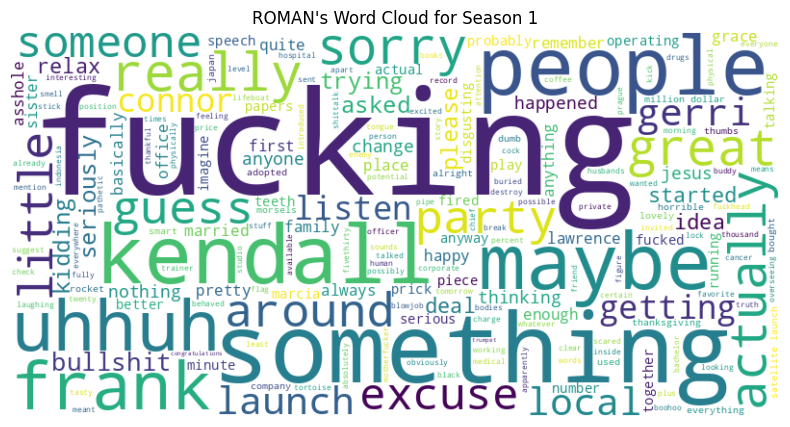

No dialogues found for Season 2, skipping word cloud.


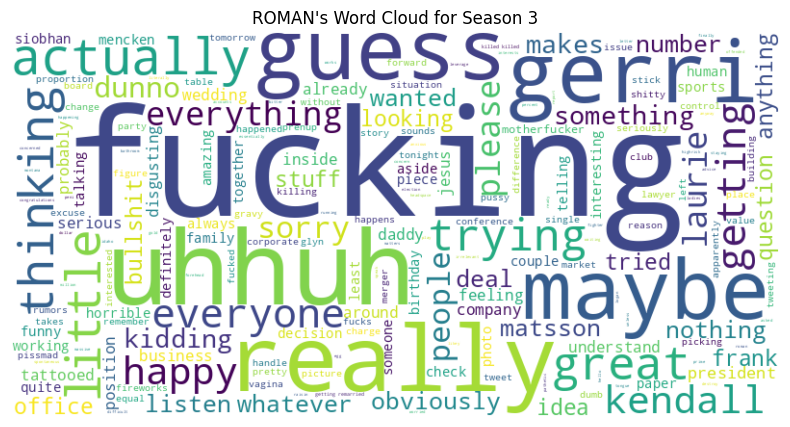

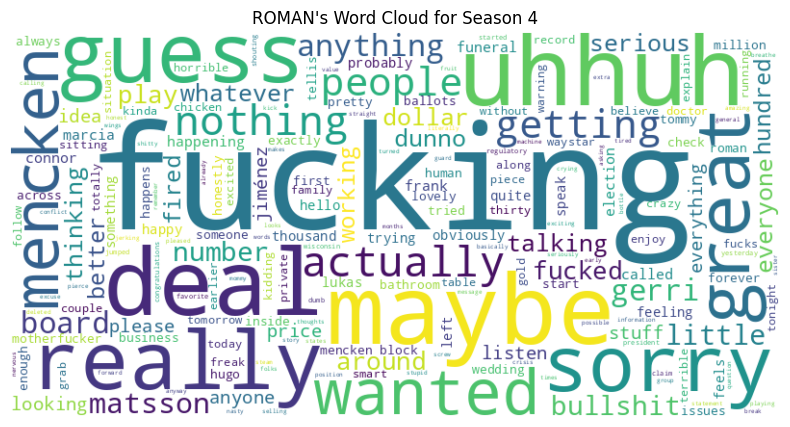

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Example: Word frequency analysis for each season
for season, tokens in tokenized_dialogues.items():
    word_freq = Counter(tokens)
    print(f"Most common words in {season}: {word_freq.most_common(10)}")
# Generate and display word clouds for each season
for season, tokens in tokenized_dialogues.items():
    if tokens:  # Check if the season has any tokens
        # Join tokens into a single string
        text = ' '.join(tokens)

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'ROMAN\'s Word Cloud for {season}')
        plt.show()
    else:
        print(f"No dialogues found for {season}, skipping word cloud.")

In [ ]:
# from nltk.util import ngrams
# from collections import Counter

# def get_ngrams(tokens, n=2):
#     n_grams = ngrams(tokens, n)
#     return Counter(n_grams)

# # Example: Bigram analysis for each season
# for season, tokens in tokenized_dialogues.items():
#     bigrams = get_ngrams(tokens, n=2)
#     print(f"Most common bigrams in {season}: {bigrams.most_common(10)}")

In [ ]:
# import nltk
# nltk.download('vader_lexicon')

In [ ]:
# from nltk.sentiment import SentimentIntensityAnalyzer

# def analyze_sentiment(dialogues):
#     sia = SentimentIntensityAnalyzer()
#     sentiment_scores = [sia.polarity_scores(dialogue) for dialogue in dialogues]
#     return sentiment_scores

# # Example: Sentiment analysis for each season
# for season, dialogues in roman_dialogues_dict.items():
#     if dialogues:  # Check if the season has any dialogues
#         sentiments = analyze_sentiment(dialogues)
#         avg_sentiment = sum(d['compound'] for d in sentiments) / len(sentiments)
#         print(f"Average sentiment in {season}: {avg_sentiment}")
#     else:
#         print(f"No dialogues found for {season}, skipping sentiment analysis.")

**Results above:** Roman was overall neutral in his language. However, we see a slight increase in positivity from season 1 to 3, and then a decrease in season 4. Does that reflect his feelings throughout the progress of the show?

In [ ]:
# def lexical_diversity(tokens):
#     if len(tokens) == 0:  # Check if the token list is empty
#         return 0  # Return 0 or another appropriate value for empty lists
#     return len(set(tokens)) / len(tokens)

# # Example: Lexical diversity for each season
# for season, tokens in tokenized_dialogues.items():
#     if len(tokens) > 0:  # Ensure tokens list is not empty
#         diversity = lexical_diversity(tokens)
#         print(f"Lexical diversity in {season}: {diversity}")
#     else:
#         print(f"No dialogues found for {season}, skipping lexical diversity calculation.")

The drop in lexical diversity in Season 4 suggests that Roman's dialogue in this season has become slightly more repetitive compared to the earlier seasons.
A diversity score of 0.5203 is still relatively high, but the decrease compared to Seasons 1 and 3 could indicate that the scriptwriters used more recurring phrases or that Roman's character is focusing on specific themes or ideas more consistently in this season.
The slight drop in lexical diversity might indicate a shift in his character or the situations he finds himself in, where his language becomes more focused or repetitive, perhaps due to increased stress, responsibility, or consistent themes.

In [ ]:
def count_swear_words(tokens):
    swear_words = {'fuck', 'fucking', 'fuckin', 'shit', 'damn', 'asshole', 'bitch', 'dick', 'cock', 'cunt', 'pussy', 'motherfucker'}
    return sum(1 for token in tokens if token in swear_words)

# Example: Swear word count for each season
for season, tokens in tokenized_dialogues.items():
    swear_count = count_swear_words(tokens)
    print(f"Swear word count in {season}: {swear_count}")

Swear word count in Season 1: 64
Swear word count in Season 2: 0
Swear word count in Season 3: 78
Swear word count in Season 4: 112


In [ ]:
# import matplotlib.pyplot as plt

# def dialogue_length_distribution(dialogues):
#     lengths = [len(word_tokenize(dialogue)) for dialogue in dialogues]
#     plt.hist(lengths, bins=20, alpha=0.75)
#     plt.xlabel('Dialogue Length (words)')
#     plt.ylabel('Frequency')
#     plt.title('Distribution of Dialogue Lengths')
#     plt.show()

# # Example: Dialogue length distribution for each season
# for season, dialogues in roman_dialogues_dict.items():
#     print(f"Dialogue length distribution in {season}:")
#     dialogue_length_distribution(dialogues)

^Not sure how much this tells us about Roman Roy's personality...

-------------------------------------------
**REVIEW:** Code below is definitely faulty. I added 'ken' and 'dad' to the characters' list since the count for Kendall and Logan was so strangely small.

I think the count for dialogues should take in consideration the character who spoke right before and/or right after Roman.

Current implementation seems to only detect if Roman explicitly says the name of another character.

In [ ]:
def character_interaction_analysis(dialogues, character_list):
    interaction_count = {character: 0 for character in character_list}
    for dialogue in dialogues:
        for character in character_list:
            if character.lower() in dialogue.lower():
                interaction_count[character] += 1

    # Sort the interaction_count dictionary by the counts in descending order
    sorted_interactions = dict(sorted(interaction_count.items(), key=lambda item: item[1], reverse=True))
    return sorted_interactions

# Example: Character interaction analysis
character_list = ['kendall', 'ken', 'dad', 'logan', 'shiv', 'siobhan', 'tom', 'greg', 'connor']
for season, dialogues in roman_dialogues_dict.items():
    interactions = character_interaction_analysis(dialogues, character_list)
    print(f"Character interactions in {season}: {interactions}")

Character interactions in Season 1: {'dad': 35, 'tom': 20, 'ken': 16, 'shiv': 15, 'kendall': 13, 'connor': 7, 'greg': 5, 'logan': 1, 'siobhan': 0}
Character interactions in Season 2: {'kendall': 0, 'ken': 0, 'dad': 0, 'logan': 0, 'shiv': 0, 'siobhan': 0, 'tom': 0, 'greg': 0, 'connor': 0}
Character interactions in Season 3: {'dad': 86, 'ken': 32, 'shiv': 29, 'tom': 10, 'kendall': 9, 'siobhan': 4, 'greg': 3, 'logan': 2, 'connor': 2}
Character interactions in Season 4: {'dad': 89, 'ken': 50, 'shiv': 37, 'tom': 25, 'connor': 7, 'greg': 6, 'kendall': 1, 'logan': 1, 'siobhan': 1}


**(UPDATE ANALYSIS)** The interaction analysis shows that Roman's character increasingly revolves around his relationships with Shiv and Tom, especially in the later seasons. This shift in focus could be driven by changes in the family's power dynamics, Roman's growing influence, or evolving alliances within the Roy family. Meanwhile, Kendall and Logan's reduced presence in Roman's interactions suggests a potential distancing or change in the nature of their relationships.

**Why are interactions with Logan and Kendall so low? Is this accurate?**

-------------------------------------------
**Sarcasm Detection:**

(I don't have labeled data for sarcasm, manually labeling the dataset would take too long. It would be cool, but difficult, to crowdsource the labeling as an online game. "Determine if the following dialogue from *Succession* contains sarcasm or not")

ANOTHER OPTION: Transfer Learning

In [ ]:
!pip install tensorflow

Export dialogues for manual labeling (using Google Sheets)

In [ ]:
import pandas as pd

# Create a DataFrame with the text and an empty "Is_Sarcastic" column
df = pd.DataFrame({'text': roman_dialogues, 'Is_Sarcastic': None})  # None means unlabelled for now

# Save to CSV (you can specify a path where you'd like to save it)
df.to_csv('roman_roy_sarcasm_labels.csv', index=False)
print("CSV file saved!")

CSV file saved!


In [ ]:
!pip install --upgrade gspread
from google.colab import auth
auth.authenticate_user()

Read Labeled dataset for training

In [ ]:
import gspread
import pandas as pd
from google.auth import default

# Authenticate and access Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# Open the Google Sheet by name
sheet = gc.open('roman_roy_sarcasm_labeled').sheet1  # Adjust if you have more than one sheet

# Get all values from the sheet
rows = sheet.get_all_values()

# Convert the data to a DataFrame
labeled_df = pd.DataFrame(rows[1:], columns=rows[0])  # Assuming the first row is the header

# Display the DataFrame
print(labeled_df.head())

                                                text Is_Sarcastic
0                    Um, no. Next. Right, fuckchops?            0
1                                          Exciting.            1
2                                           Hard no.            0
3  But go on. I do like them. We do. It’s just th...            1
4                      I mean we can be honest here?            0


Try different tokenization for training the model.

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

def tokenize(dialogues):
    stop_words = set(stopwords.words('english'))  # Get the list of stopwords
    all_tokens = []
    for dialogue in dialogues:
        # Remove special characters but keep common punctuation for sarcasm detection (like question marks, exclamations)
        cleaned_dialogue = re.sub(r'[^\w\s\?]', '', dialogue)  # Remove punctuation except ?, !

        # Tokenize the dialogue
        tokens = word_tokenize(cleaned_dialogue.lower())  # Tokenize and convert to lowercase

        # Only remove truly unimportant stopwords, keep negations like "not" or "no"
        cleaned_tokens = []
        for token in tokens:
            if token not in stop_words or token in ['no', 'not', 'isn’t', 'don’t']:  # Keep negations and crucial words
                cleaned_tokens.append(token)

        all_tokens.extend(cleaned_tokens)

    return all_tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
nltk.download('punkt_tab')
# Tokenize and clean all dialogues
labeled_df['cleaned_text'] = labeled_df['text'].apply(lambda x: ' '.join(tokenize([x])))

# Check the cleaned text
print(labeled_df[['text', 'cleaned_text']].head())


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                                text  \
0                    Um, no. Next. Right, fuckchops?   
1                                          Exciting.   
2                                           Hard no.   
3  But go on. I do like them. We do. It’s just th...   
4                      I mean we can be honest here?   

                   cleaned_text  
0  um no next right fuckchops ?  
1                      exciting  
2                       hard no  
3    go like theyre kind shitty  
4                 mean honest ?  


 **Filter Out Rows with Missing Labels**:
 We can filter out the rows that have missing values in the "Is_Sarcastic" column so that you only use the labeled data for training.

In [ ]:
import numpy as np

# Replace empty strings with NaN, then fill NaN with 0, and convert to integers
labeled_df['Is_Sarcastic'] = labeled_df['Is_Sarcastic'].replace('', np.nan).fillna(0).astype(int)

# Proceed with the rest of the process
X = labeled_df['cleaned_text']
y = labeled_df['Is_Sarcastic']

In [ ]:
from sklearn.model_selection import train_test_split

# Use the cleaned text for training
X = labeled_df['cleaned_text']
y = labeled_df['Is_Sarcastic'].astype(int)  # Ensure labels are integers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the size of the splits
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 870 samples
Test set: 218 samples


**Converting Text to Sequences of Integers for the Model**

Deep learning models require numeric input

In [ ]:
# Build a vocabulary manually from your tokenized training data
vocab = set([word for dialogue in X_train for word in dialogue.split()])  # Create vocabulary from training set
word_index = {word: i+1 for i, word in enumerate(vocab)}  # Assign a unique index to each word

# Convert each dialogue into a sequence of integers based on the word index
def text_to_sequence(dialogue, word_index):
    return [word_index.get(word, 0) for word in dialogue.split()]

# Convert training and testing data to sequences
X_train_sequences = [text_to_sequence(dialogue, word_index) for dialogue in X_train]
X_test_sequences = [text_to_sequence(dialogue, word_index) for dialogue in X_test]

# Pad the sequences to ensure they are of the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 100  # Adjust as needed for your data
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Check padded sequences
print(X_train_padded.shape)
print(X_test_padded.shape)

(870, 100)
(218, 100)


**Training the Model**

**Embedding Layer for Word Vectors**
 map each integer (representing a word) to a dense vector of real numbers. These embeddings **capture semantic relationships** between words, so, for instance, similar words (e.g., "happy" and "joyful") have similar vector representations.

In [ ]:
import tensorflow as tf

# Build a Neural Network model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=16, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
num_epochs = 10
history = model.fit(
    X_train_padded,
    y_train,
    epochs=num_epochs,
    validation_data=(X_test_padded, y_test),
    verbose=2
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
28/28 - 4s - 150ms/step - accuracy: 0.8057 - loss: 0.5306 - val_accuracy: 0.7982 - val_loss: 0.5117
Epoch 2/10
28/28 - 0s - 12ms/step - accuracy: 0.8057 - loss: 0.4917 - val_accuracy: 0.7982 - val_loss: 0.5035
Epoch 3/10
28/28 - 1s - 24ms/step - accuracy: 0.8057 - loss: 0.4904 - val_accuracy: 0.7982 - val_loss: 0.5035
Epoch 4/10
28/28 - 0s - 14ms/step - accuracy: 0.8057 - loss: 0.4900 - val_accuracy: 0.7982 - val_loss: 0.5037
Epoch 5/10
28/28 - 1s - 22ms/step - accuracy: 0.8057 - loss: 0.4903 - val_accuracy: 0.7982 - val_loss: 0.5039
Epoch 6/10
28/28 - 1s - 20ms/step - accuracy: 0.8057 - loss: 0.4902 - val_accuracy: 0.7982 - val_loss: 0.5034
Epoch 7/10
28/28 - 1s - 23ms/step - accuracy: 0.8057 - loss: 0.4891 - val_accuracy: 0.7982 - val_loss: 0.5040
Epoch 8/10
28/28 - 1s - 24ms/step - accuracy: 0.8057 - loss: 0.4891 - val_accuracy: 0.7982 - val_loss: 0.5032
Epoch 9/10
28/28 - 1s - 24ms/step - accuracy: 0.8057 - loss: 0.4884 - val_accuracy: 0.7982 - val_loss: 0.5032
Epoch 10/

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict sarcasm in new dialogues
new_dialogues = ["Oh great, I am going to kill myself.", "‘Hey, Doctor Sarcasmo, did we ask you to squeak? Stand easy, pitch wall."]
new_dialogues_tokenized = [' '.join(tokenize([dialogue])) for dialogue in new_dialogues]  # use function tokenize() OR tokenize_and_clean()
new_sequences = [text_to_sequence(dialogue, word_index) for dialogue in new_dialogues_tokenized]
new_padded = pad_sequences(new_sequences, maxlen=max_length, padding='post', truncating='post')

predictions = model.predict(new_padded)
sarcasm_labels = ['Sarcasm' if pred > 0.5 else 'Not Sarcasm' for pred in predictions]

# Display predictions
for dialogue, label in zip(new_dialogues, sarcasm_labels):
    print(f"Dialogue: {dialogue}\nPrediction: {label}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7990 - loss: 0.5042  
Test Loss: 0.5042635202407837
Test Accuracy: 0.7981651425361633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Dialogue: Oh great, I am going to kill myself.
Prediction: Not Sarcasm
Dialogue: ‘Hey, Doctor Sarcasmo, did we ask you to squeak? Stand easy, pitch wall.
Prediction: Not Sarcasm


**Try to fine-tune a Pre-Trained Transformer Model**

 Pre-trained transformer models (like BERT) already have a rich understanding of language, as they have been trained on large corpora. We can fine-tune them on our specific sarcasm dataset, which means the model can start with a strong ability to understand language and then specialize in sarcasm detection.

In [ ]:
# Install the Transformers library
!pip install transformers
!pip install --upgrade tensorflow keras

**Load BERT and Tokenizer**

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the BERT model for binary classification (sarcasm vs. not sarcasm)
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Tokenize Your Dataset for BERT**

In [ ]:
# Tokenize the dataset
def tokenize_data(texts, tokenizer, max_length=100):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

# Tokenize the training and testing data
train_encodings = tokenize_data(X_train.tolist(), tokenizer)
test_encodings = tokenize_data(X_test.tolist(), tokenizer)

Convert the labels into TensorFlow tensors and prepare the data for training.

In [ ]:
# Convert labels to tensors
train_labels = tf.convert_to_tensor(y_train.tolist())
test_labels = tf.convert_to_tensor(y_test.tolist())

**Compile and Fine-Tune the BERT Model**



In [ ]:
from tensorflow.keras.optimizers import Adam
# Compile the model with an optimizer and loss function
model.compile(
    # optimizer=Adam(learning_rate=2e-5),
    optimizer='adam', # Use the string identifier 'adam'
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Fine-tune the model
history = model.fit(
    train_encodings['input_ids'],  # Tokenized text data
    train_labels,                  # Corresponding labels
    validation_data=(test_encodings['input_ids'], test_labels),
    epochs=3,                       # Adjust the number of epochs as needed
    batch_size=16                   # Adjust batch size based on available memory
)

Epoch 1/3
55/55 [==============================] - 796s 13s/step - loss: 0.6082 - accuracy: 0.7655 - val_loss: 0.6605 - val_accuracy: 0.7982
Epoch 2/3
55/55 [==============================] - 644s 12s/step - loss: 0.5281 - accuracy: 0.7954 - val_loss: 0.6487 - val_accuracy: 0.7982
Epoch 3/3
55/55 [==============================] - 675s 12s/step - loss: 0.5145 - accuracy: 0.8023 - val_loss: 0.5030 - val_accuracy: 0.7982


Evaluate the Model

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_encodings['input_ids'], test_labels)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

7/7 [==============================] - 45s 6s/step - loss: 0.5030 - accuracy: 0.7982
Test Loss: 0.5030292868614197
Test Accuracy: 0.7981651425361633


Make predictions on new data

In [ ]:
# Function to predict sarcasm
def predict_sarcasm(dialogues):
    encodings = tokenize_data(dialogues, tokenizer)
    predictions = model.predict(encodings['input_ids']).logits
    predicted_labels = tf.argmax(predictions, axis=1).numpy()
    return ["Sarcasm" if label == 1 else "Not Sarcasm" for label in predicted_labels]

# Test with new examples
new_dialogues = ["Oh great, I love doing all the paperwork without getting paid!", "What an amazing day!"]
predictions = predict_sarcasm(new_dialogues)
print(predictions)

1/1 [==============================] - 4s 4s/step
['Not Sarcasm', 'Not Sarcasm']


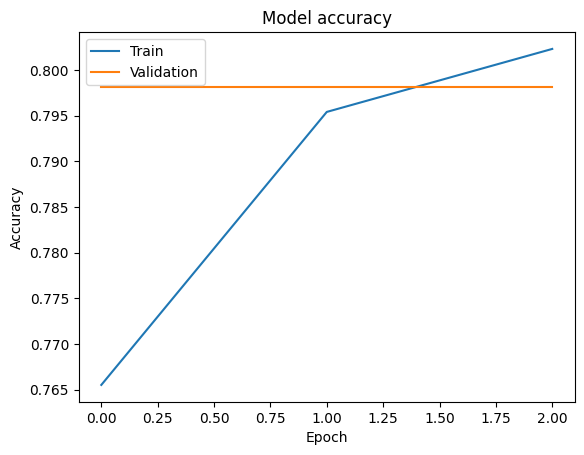

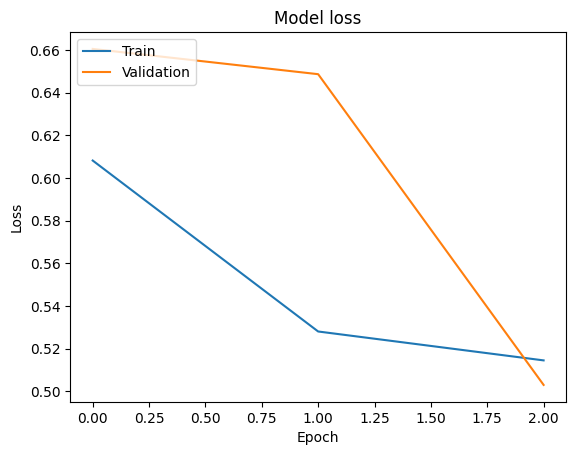

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Confusion Matrix:**

7/7 [==============================] - 57s 8s/step


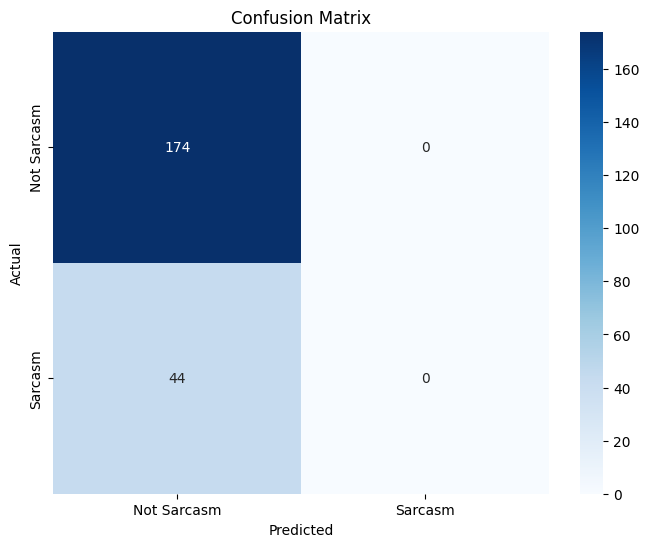

              precision    recall  f1-score   support

 Not Sarcasm       0.80      1.00      0.89       174
     Sarcasm       0.00      0.00      0.00        44

    accuracy                           0.80       218
   macro avg       0.40      0.50      0.44       218
weighted avg       0.64      0.80      0.71       218



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(test_encodings['input_ids'])
y_pred_classes = tf.argmax(y_pred.logits, axis=1).numpy()

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcasm', 'Sarcasm'], yticklabels=['Not Sarcasm', 'Sarcasm'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report

print(classification_report(test_labels, y_pred_classes, target_names=['Not Sarcasm', 'Sarcasm']))

Accuracy is 80% but precision for the positive class is 0, hence, the model is not detecting any Sarcasm.


P.S.: Accuracy can be misleading



---


IDEA: **Class Imbalance Techniques** (if applicable)
If your dataset is imbalanced (e.g., more non-sarcastic than sarcastic dialogues), consider applying  this technique to handle the imbalance:

Class weights: You can adjust the weights of the classes to give more importance to sarcastic examples. This approach will tell the model to give more importance to sarcastic examples, which should improve the model’s performance on the minority class.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming `y_train` contains the labels (0 for non-sarcastic, 1 for sarcastic)
class_weights = compute_class_weight(
    class_weight='balanced',  # This will automatically compute the weights
    classes=np.unique(y_train),  # The two classes: 0 (non-sarcastic), 1 (sarcastic)
    y=y_train                  # The labels from the training data
)

# Convert the result into a dictionary
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.6205420827389444, 1: 2.57396449704142}


In [ ]:
# Compile the model with an optimizer and loss function
model.compile(
    # optimizer=Adam(learning_rate=2e-5),
    optimizer='adam', # Use the string identifier 'adam'
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model with class weights
history = model.fit(
    train_encodings['input_ids'],
    train_labels,
    validation_data=(test_encodings['input_ids'], test_labels),
    epochs=3,
    batch_size=16,
    class_weight=class_weights  # Apply the class weights here
)

Epoch 1/3
55/55 [==============================] - 804s 14s/step - loss: 0.6449 - accuracy: 0.7667 - val_loss: 0.5086 - val_accuracy: 0.7982
Epoch 2/3
55/55 [==============================] - 747s 14s/step - loss: 0.5619 - accuracy: 0.8011 - val_loss: 0.5562 - val_accuracy: 0.7982
Epoch 3/3
55/55 [==============================] - 681s 12s/step - loss: 0.5601 - accuracy: 0.8057 - val_loss: 0.5030 - val_accuracy: 0.7982


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_encodings['input_ids'], test_labels)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

7/7 [==============================] - 50s 7s/step - loss: 0.5030 - accuracy: 0.7982
Test Loss: 0.5029581189155579
Test Accuracy: 0.7981651425361633


In [ ]:
# Function to predict sarcasm
def predict_sarcasm(dialogues):
    encodings = tokenize_data(dialogues, tokenizer)
    predictions = model.predict(encodings['input_ids']).logits
    predicted_labels = tf.argmax(predictions, axis=1).numpy()
    return ["Sarcasm" if label == 1 else "Not Sarcasm" for label in predicted_labels]

# Test with new examples
new_dialogues = ["Oh great, I love doing all the paperwork without getting paid!", "What an amazing day!"]
predictions = predict_sarcasm(new_dialogues)
print(predictions)

1/1 [==============================] - 5s 5s/step
['Not Sarcasm', 'Not Sarcasm']


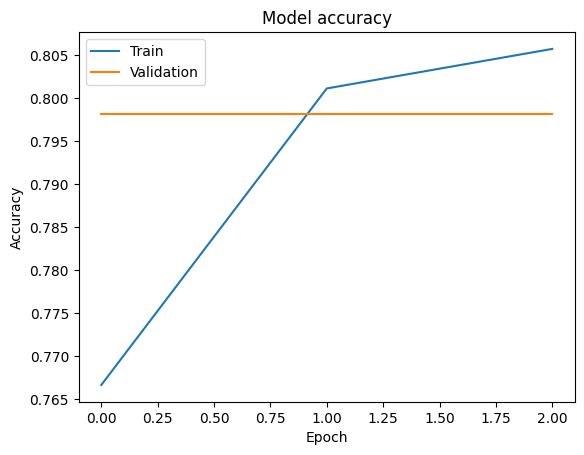

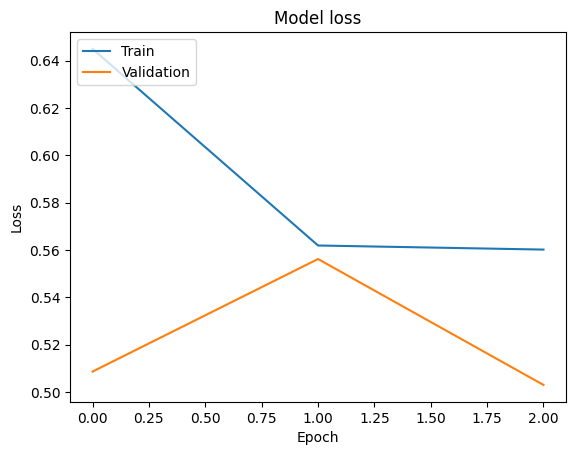

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

7/7 [==============================] - 61s 7s/step


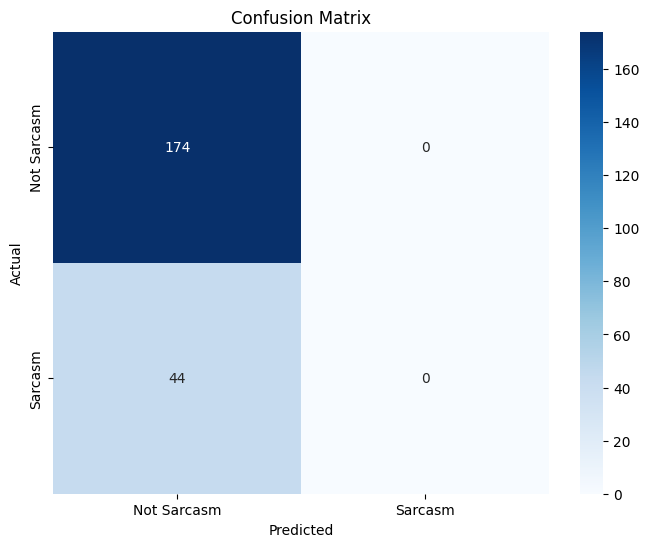

              precision    recall  f1-score   support

 Not Sarcasm       0.80      1.00      0.89       174
     Sarcasm       0.00      0.00      0.00        44

    accuracy                           0.80       218
   macro avg       0.40      0.50      0.44       218
weighted avg       0.64      0.80      0.71       218



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(test_encodings['input_ids'])
y_pred_classes = tf.argmax(y_pred.logits, axis=1).numpy()

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcasm', 'Sarcasm'], yticklabels=['Not Sarcasm', 'Sarcasm'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report

print(classification_report(test_labels, y_pred_classes, target_names=['Not Sarcasm', 'Sarcasm']))

Let's try **Oversampling** now

Epoch 1/3
88/88 [==============================] - 76s 272ms/step - loss: 0.7591 - accuracy: 0.4700 - val_loss: 0.7705 - val_accuracy: 0.2018
Epoch 2/3
88/88 [==============================] - 19s 213ms/step - loss: 0.7208 - accuracy: 0.5185 - val_loss: 0.6485 - val_accuracy: 0.7982
Epoch 3/3
7/7 [==============================] - 4s 133ms/step
              precision    recall  f1-score   support

 Not Sarcasm       0.80      1.00      0.89       174
     Sarcasm       0.00      0.00      0.00        44

    accuracy                           0.80       218
   macro avg       0.40      0.50      0.44       218
weighted avg       0.64      0.80      0.71       218



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


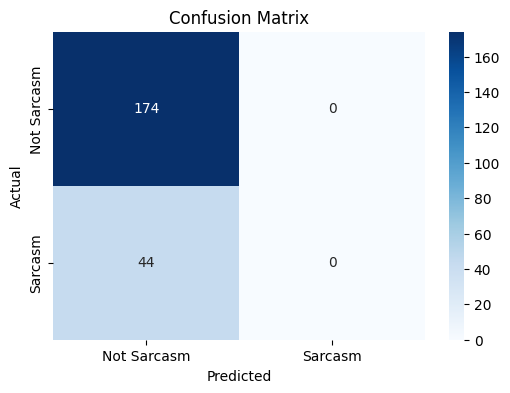

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Apply random oversampling to increase sarcastic examples
oversampler = RandomOverSampler(sampling_strategy='minority')  # Oversample sarcasm class
X_train_resampled, y_train_resampled = oversampler.fit_resample(train_encodings['input_ids'], y_train)

model.compile(
    # optimizer=Adam(learning_rate=2e-5),
    optimizer='adam', # Use the string identifier 'adam'
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model with the new balanced dataset
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(test_encodings['input_ids'], test_labels),
    epochs=3,
    batch_size=16
)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(test_encodings['input_ids']).logits
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# Print classification report
print(classification_report(test_labels, y_pred_classes, target_names=['Not Sarcasm', 'Sarcasm']))

# Plot confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcasm', 'Sarcasm'], yticklabels=['Not Sarcasm', 'Sarcasm'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



**Possible Issues and Explanations**:
*The Model Isn’t Learning Sarcasm Properly*

- BERT is pre-trained for general language understanding, NOT sarcasm detection.

- It doesn’t inherently understand sarcasm unless fine-tuned well on a large sarcasm-specific dataset. My dataset may not have enough labeled sarcastic examples for effective fine-tuning.
- Sarcasm often depends on context, tone, and prior knowledge, making it hard to detect with just text-based models. (should I train the model with the dialogues of characters to whom Roman is talking/responding?)

**IDEA:**
Instead of just fine-tuning on your dataset, you could first pretrain the model on a larger sarcasm dataset (e.g., the Kaggle Sarcasm Dataset), THEN fine-tune on Roman Roy’s dialogues.